In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 16.8MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 481kB 47.4MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621226 sha256=f5819c189280ef1a572765f979c3975acb2d084ff5d7207be3597f548fdd4517
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2021.1-py2.py3-none-any.whl size=60415 sha256=94d822394823c2b6a2f297d0a05f63327052f33d42c889f9e4645d28eeced9a8
  Stored in directory: /root/.cache/pip/wheels/5d/85/10/7da05d77b47f2cb503e5c4185ba82187d0b6b6736b3c6641e0
  Created wheel for mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=2d02d7ccb27da47097a603e14a1ecd3d16414dcff02b19b920c80edd01999441
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
Successfully built pycuda pytools mako


In [30]:
!pip install py-cpuinfo

     |████████████████████████████████| 102kB 8.3MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20072 sha256=77fbda5f5e65b73538d12cdfc44bb3f926203e5b9c005fe393db800449c9970d
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


In [31]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Xeon(R) CPU @ 2.20GHz'

In [32]:
!nvidia-smi

Wed Jan 27 18:55:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |    210MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
from pycuda import driver, compiler, gpuarray
import pycuda.autoinit
import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow
from pycuda.compiler import SourceModule

In [34]:
mod = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;

__global__ void bil_gpu(unsigned int * __restrict__ d_result, const int M, const int N, const float sigma_d, const float sigma_r)
{
    const int i = threadIdx.x + blockDim.x * blockIdx.x;
    const int j = threadIdx.y + blockDim.y * blockIdx.y;


    if ((i<M)&&(j<N)) {
        float s = 0;
        float c = 0;
        for (int l = i-1; l <= i+1; l++){
            for (int k = j-1; k <= j+1; k++){
                float img1 = tex2D(tex, k, l)/255;
                float img2 = tex2D(tex, i, j)/255;
                float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                float r = exp(-pow((img1 - img2)*255, 2) / pow(sigma_r, 2));
                c += g*r;
                s += g*r*tex2D(tex, k, l);
            }
        }
        d_result[i*N + j] = s / c;
    }


}
""")

In [35]:
#вычисляем пиксель
def pixel(image, i, j, sigma_d, sigma_r):    
    c = 0
    s = 0
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            g = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
            i1 = image[k, l]
            i2 = image[i, j]
            r = np.exp(-((i1 - i2)** 2) / sigma_r ** 2)
            c += g*r
            s += g*r*image[k, l]
    result = s / c
    return result

#создаем новое изображение
def bil_cpu(image, sigma_d, sigma_r):
    new_image = np.zeros(image.shape)
    width = image.shape[0]
    height = image.shape[1]
    for i in range(1, width-1):
        for j in range(1, height-1):
            new_image[i, j] = pixel(image, i, j, sigma_d, sigma_r)
    return new_image

Оригинал


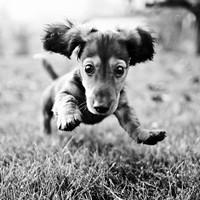

In [36]:
IMG = '/content/drive/MyDrive/Лаба/st_244.jpg'
image = cv2.imread(IMG, cv2.IMREAD_GRAYSCALE)

print("Оригинал")
cv2_imshow(image)

M, N = image.shape
sigma_d = 300
sigma_r = 300

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.


Изображение CPU


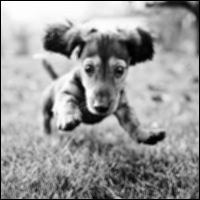

Время на CPU:  2.84375


In [42]:
cpu_start = time.time()
cpu_result = bil_cpu(image, sigma_d, sigma_r)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/Лаба/cpu_output.bmp', cpu_result)
print("Изображение CPU")
cv2_imshow(cpu_result)
print('Время на CPU: ', round(cpu_time,5))

Изображение GPU


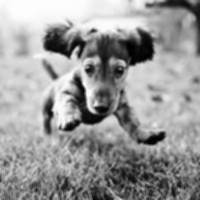

Время на GPU:  0.00502


In [43]:
gpu_result = np.zeros((M, N), dtype=np.uint32)
block = (32, 1, 1)
grid = (int(np.ceil(M/block[0])),int(np.ceil(N/block[1])))

bil_gpu = mod.get_function("bil_gpu")

gpu_start = time.time()

tex = mod.get_texref("tex")
tex.set_filter_mode(driver.filter_mode.LINEAR)
tex.set_address_mode(0, driver.address_mode.MIRROR)
tex.set_address_mode(1, driver.address_mode.MIRROR)
driver.matrix_to_texref(image.astype(np.uint32), tex, order="C")

bil_gpu(driver.Out(gpu_result), np.int32(M), np.int32(N), np.float32(sigma_d), np.float32(sigma_r), block=block, grid=grid, texrefs=[tex])

gpu_time = time.time() - gpu_start
print("Изображение GPU")
cv2.imwrite('/content/drive/MyDrive/Лаба/gpu_output.bmp', gpu_result.astype(np.uint8))
cv2_imshow(gpu_result)
print('Время на GPU: ', round(gpu_time,5))

In [44]:
print("Ускорение: ",cpu_time/gpu_time)

Ускорение:  566.1180881864351
